In [1]:
# -*- coding: utf-8 -*- 
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the CICIDS2017 dataset. 
# implemented Advanced Ensemble techniques: Blending 

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/Intrusion_Detection_System_IDS/Advanced_Ensemble_techniques/Stacking/CICIDS2017_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

# Fill nan values
main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())

# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)

# Checking numbers of missing values on the df
# main_df_2.isna().sum().sum()

sample_df_1 = main_df_2.copy()

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

/tmp/ipykernel_190232/2600299469.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


 Extract subsample of data: 
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [2]:
# Label encoding to convert categorical data to numerical data
le = LabelEncoder()
sample_df_1['Label'] = le.fit_transform(sample_df_1['Label'])

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
0     2096484
4      172849
2      128016
10      90819
3       10286
7        5933
6        5385
5        5228
11       3219
1        1953
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [3]:
# sample_df_1.shape
# sample_df_1.info()

# Take a 40% random sample of the dataset
# sample_df_1 = sample_df_1.sample(frac=0.01, random_state=42)

print("Sampled Dataset Overview:")
# print(sample_df_2.head())
# print (sample_df_2.info())

dropped_df = ['Label', 'Flow Packets/s', 'Flow Bytes/s']
X = sample_df_1.drop( dropped_df, axis=1) 
y = sample_df_1['Label']  

Sampled Dataset Overview:


In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# the base models
rf_model = RandomForestClassifier(random_state=42)
mlpc_model = MLPClassifier(random_state=42)
Lr_model = LogisticRegression(random_state=42)
dst_model = DecisionTreeClassifier(random_state=42)

In [5]:
# Train base models on the training set
rf_model.fit(X_train, y_train)
mlpc_model.fit(X_train, y_train)
Lr_model.fit(X_train, y_train)
dst_model.fit(X_train, y_train)

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  args = (X, target, sample_weight, l2_reg_strength, n_threads)


DecisionTreeClassifier(random_state=42)

In [6]:
# predictions on the test set
pred1 = rf_model.predict(X_test)
pred2 = mlpc_model.predict(X_test)
pred3 = Lr_model.predict(X_test)
pred4 = dst_model.predict(X_test)

In [16]:
# here is the blending part starts, create a new dataset with the predictions of base models
blend_X_train = np.column_stack((pred1, pred2, pred3, pred4))

# Define a meta-model for blending
# meta_model = LogisticRegression(random_state=42)
meta_model = DecisionTreeClassifier(random_state=42)

# Train the meta-model on the blended predictions
meta_model.fit(blend_X_train, y_test)

# Now, let's make predictions on the test set using the base models
base_rf_model_pred = rf_model.predict(X_test)
base_mlpc_model_pred = mlpc_model.predict(X_test)
base_Lr_model_pred = Lr_model.predict(X_test)
base_dst_model_pred = dst_model.predict(X_test)

# Create a new dataset with the predictions of base models for the meta-model
blend_X_test = np.column_stack((base_rf_model_pred, base_mlpc_model_pred, base_Lr_model_pred, base_dst_model_pred))

# predictions on the test set using the meta-model
y_pred_encoded = meta_model.predict(blend_X_test)

In [8]:
# Evaluate the performance of the blending model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Blending Model Accuracy: {accuracy}")

Blending Model Accuracy: 0.9985133000180386


In [9]:
# Convert the encoded labels to the original labels by using inverse_transform 
y_pred = le.inverse_transform(y_pred_encoded)
y_test_labels = le.inverse_transform(y_test)

# mapping between numerical labels and their corresponding real labels
label_mapping = {label: le.inverse_transform([label])[0] for label in set(y_test)}
print (label_mapping)

{0: 'BENIGN', 1: 'Bot', 2: 'DDoS', 3: 'DoS GoldenEye', 4: 'DoS Hulk', 5: 'DoS Slowhttptest', 6: 'DoS slowloris', 7: 'FTP-Patator', 8: 'Heartbleed', 9: 'Infiltration', 10: 'PortScan', 11: 'SSH-Patator', 12: 'Web Attack � Brute Force', 13: 'Web Attack � Sql Injection', 14: 'Web Attack � XSS'}


In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [11]:
# Classification Report before the transform
print("\nClassification Report before the trans:")
print(classification_report(y_test, y_pred_encoded))


Classification Report before the trans:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419148
           1       0.93      0.74      0.82       403
           2       1.00      1.00      1.00     25498
           3       1.00      1.00      1.00      2032
           4       1.00      1.00      1.00     34853
           5       0.99      0.99      0.99      1038
           6       1.00      0.99      0.99      1085
           7       1.00      1.00      1.00      1160
           8       1.00      1.00      1.00         2
           9       1.00      0.75      0.86         4
          10       0.99      0.99      0.99     18187
          11       1.00      1.00      1.00       633
          12       0.72      0.90      0.80       294
          13       0.00      0.00      0.00         1
          14       0.53      0.22      0.31       135

    accuracy                           1.00    504473
   macro avg       0.88      0.84      0.85    504473
weighted avg       1.00   

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))


In [12]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))


                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    419148
                       Bot       0.93      0.74      0.82       403
                      DDoS       1.00      1.00      1.00     25498
             DoS GoldenEye       1.00      1.00      1.00      2032
                  DoS Hulk       1.00      1.00      1.00     34853
          DoS Slowhttptest       0.99      0.99      0.99      1038
             DoS slowloris       1.00      0.99      0.99      1085
               FTP-Patator       1.00      1.00      1.00      1160
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.75      0.86         4
                  PortScan       0.99      0.99      0.99     18187
               SSH-Patator       1.00      1.00      1.00       633
  Web Attack � Brute Force       0.72      0.90      0.80       294
Web Attack � Sql Injection       0.00      0.00

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  raise ValueError("average has to be one of " + str(average_options))


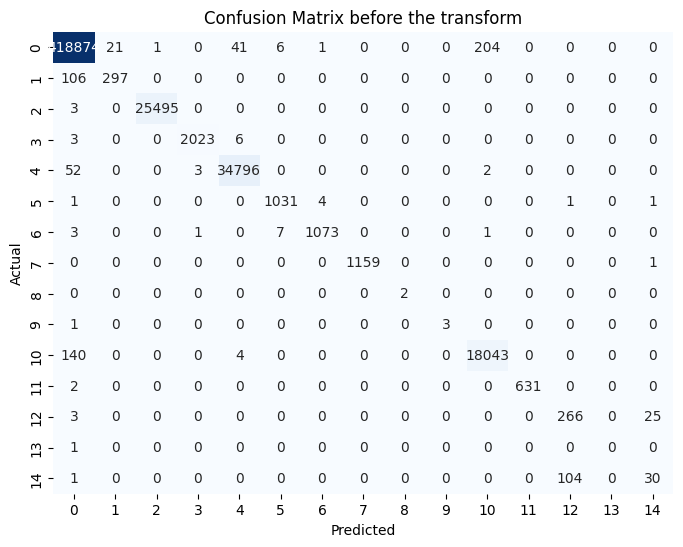

In [13]:
# Confusion Matrix before the transform
conf_mat = confusion_matrix(y_test, y_pred_encoded )

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False) 
plt.title('Confusion Matrix before the transform')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

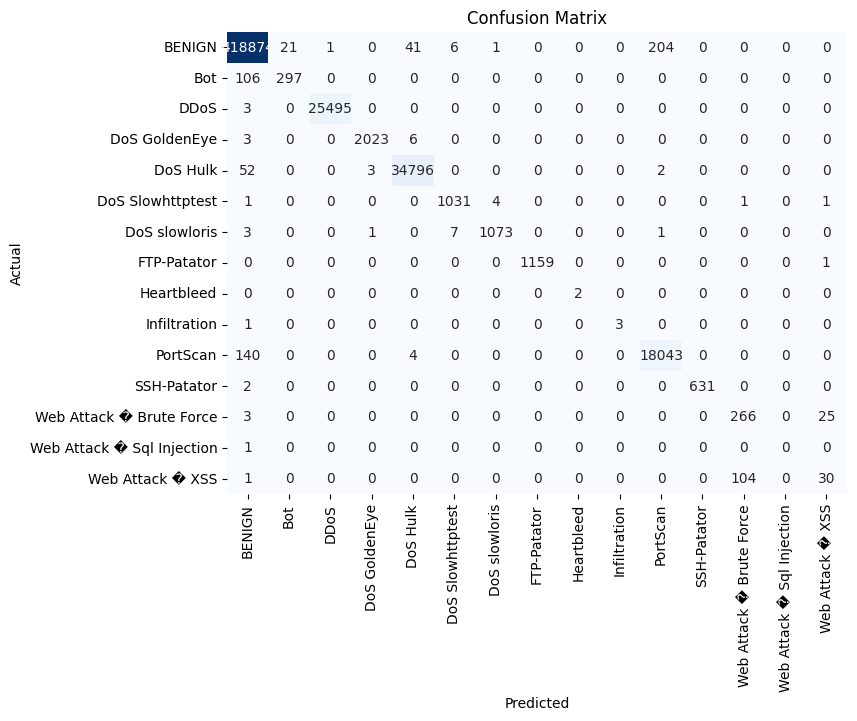

In [14]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_labels, y_pred , labels = le.classes_)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,  xticklabels=le.classes_.tolist(), yticklabels=le.classes_.tolist()) 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_190232/1943321706.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette='mako')


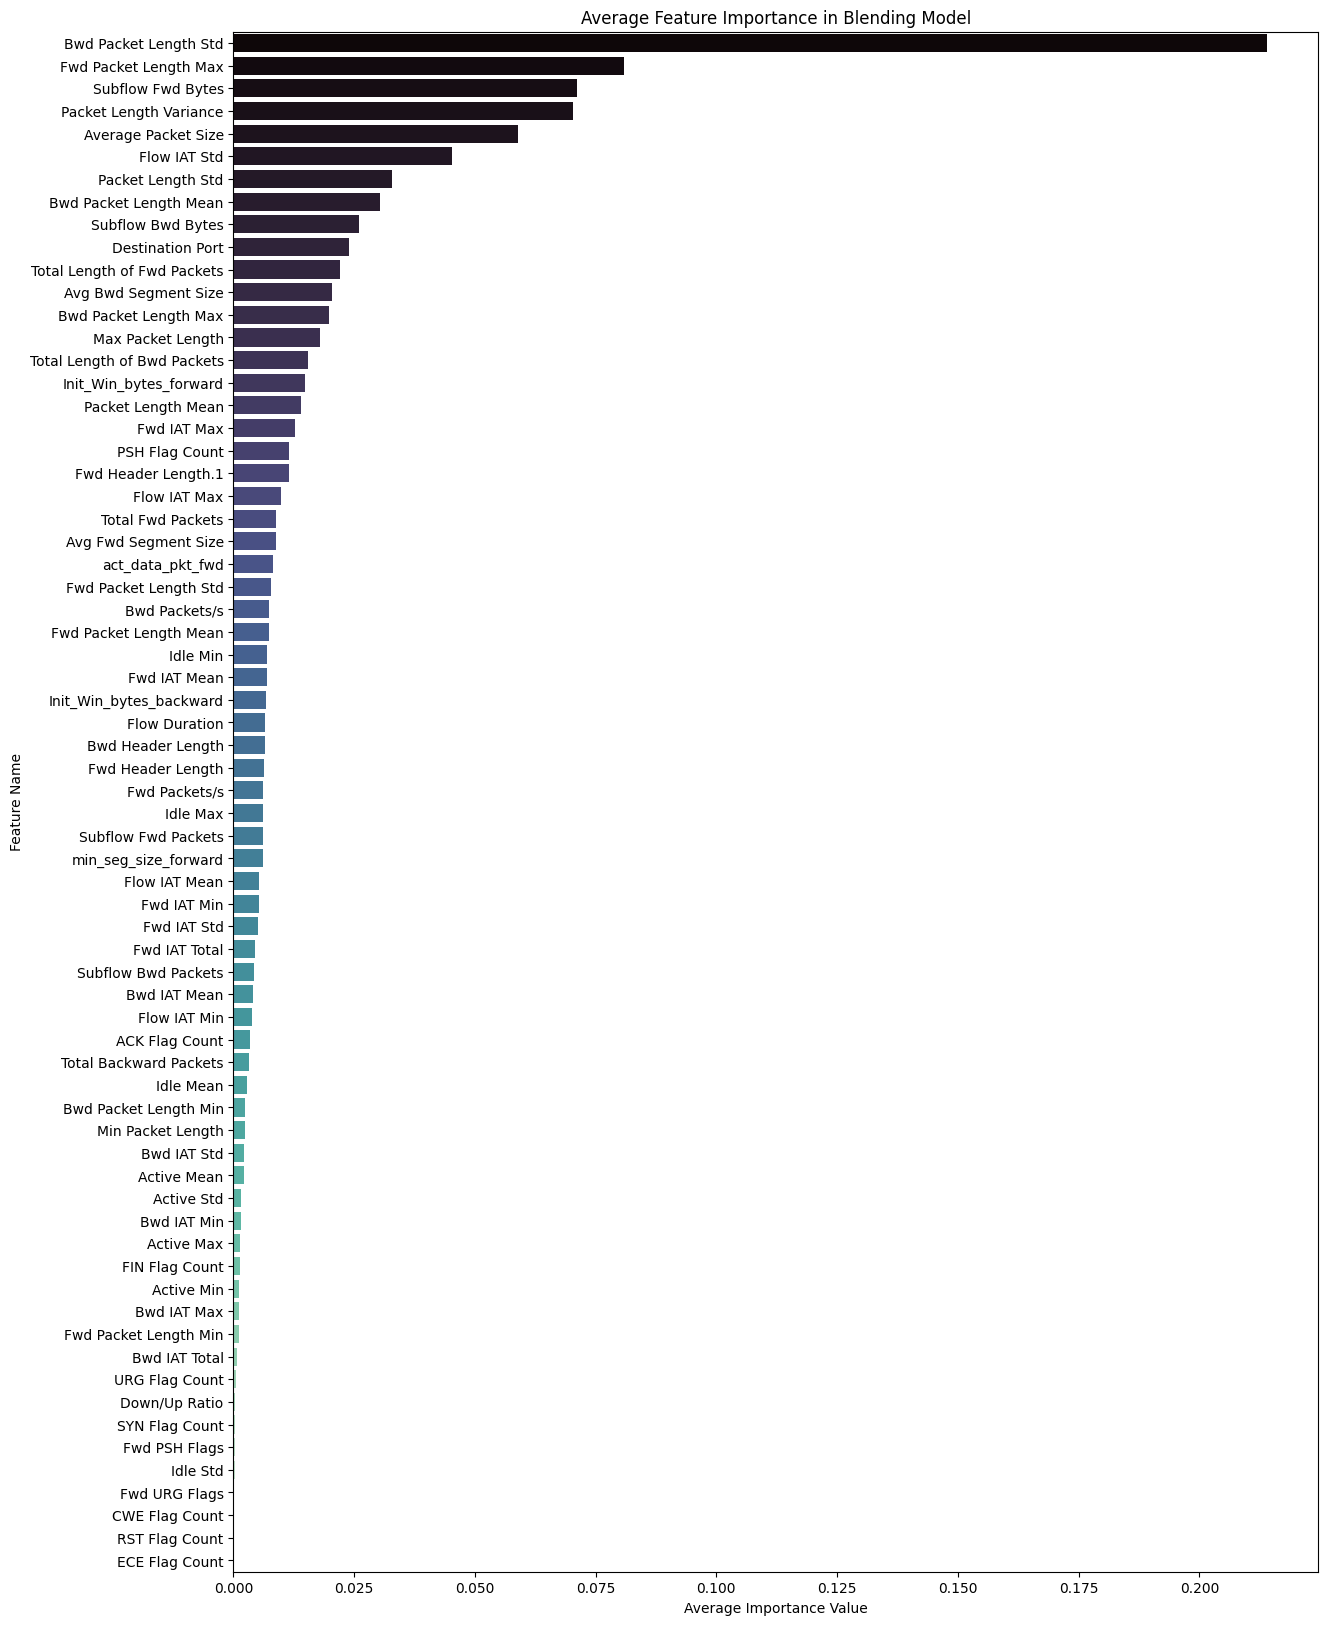

In [15]:

# Extract feature importances from base models
base_models_importances = {}

for i, model in enumerate([rf_model, Lr_model, dst_model, mlpc_model]):
    if hasattr(model, 'feature_importances_'):
        base_models_importances[f'base_model_{i}'] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(14, 20))
sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in Blending Model')
plt.show()